60
33 27


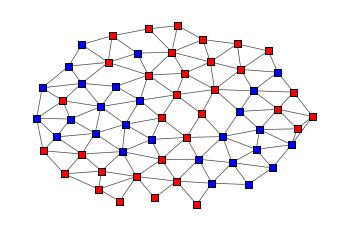

[]


In [19]:
import igraph as ig
import numpy as np
from scipy.spatial import Delaunay
import math
import matplotlib.pyplot as plt
from functools import reduce
import random
import sys

RNG = np.random.default_rng(seed=102671797463975) 

def d_minkowski(g, v1, v2, ex=2):
    def adddim(r, l):
        return r+abs(l[0] - l[1])**ex
    return (reduce(adddim, list(zip(v1['coordinates'],v2['coordinates'])), 0))**(1.0/ex)

def d_cosineSimilarity(g, v1, v2):
    dot_product = np.dot(v1['coordinates'], v2['coordinates'])
    norm_point1 = np.linalg.norm(v1['coordinates'])
    norm_point2 = np.linalg.norm(v2['coordinates'])
    if norm_point1 == 0 or norm_point2 == 0:
        return 0
    similarity = dot_product / (norm_point1 * norm_point2)
    return similarity

def d_euclidean(g, v1, v2):
    return d_minkowski(g, v1, v2, 2)


def d_manhatten(g, v1, v2):
    return d_minkowski(g, v1, v2, 1)

def d_geodesic(g, v1, v2, key='len'):
    shortestPath = v1.get_shortest_paths(v2, output="epath", weights=g.es[key])
    if shortestPath == []:
        return math.inf
    return reduce(lambda a,e: a+g.es[e][key], shortestPath[0], 0)

def d_step(g, v1, v2):
    return d_geodesic(g, v1, v2, key='count')

def d_commonNeighbors(g, v1, v2, n_hop=1):
    return len(set(g.neighborhood(v1.index, order=n_hop, mindist=1)).intersection(set(g.neighborhood(v2.index, order=n_hop, mindist=1))))

def d_jaccard(g, v1, v2, n_hop=1):
    divisor = len(set(g.neighborhood(v1.index, order=n_hop, mindist=1)).union(set(g.neighborhood(v2.index, order=n_hop, mindist=1))))
    if divisor == 0:
        return math.inf
    return d_commonNeighbors(g, v1, v2, n_hop=n_hop) / divisor

def d_randomWalk(g, v1, v2, walk_length=20, num_walks=15, retminlen=False):
    def rwincWL(walkl):
        successfullwalksv12 = 0
        unsuccessfulwalksv12 = 0
        succwalklistv12 = []
        for i in range(num_walks):
            walk = g.random_walk(start=v1.index, steps=walkl)
            if v2.index in walk:
                successfullwalksv12 += 1
                succwalklistv12.append(walk)
            else:
                unsuccessfulwalksv12 += 1

        successfullwalksv21 = 0
        unsuccessfulwalksv21 = 0
        succwalklistv21 = []
        for i in range(num_walks):
            walk = g.random_walk(start=v2.index, steps=walkl)
            if v1.index in walk:
                successfullwalksv21 += 1
                succwalklistv21.append(walk)
            else:
                unsuccessfulwalksv21 += 1

        if successfullwalksv12 == 0 or successfullwalksv21 == 0:
            return math.inf
        
        return (successfullwalksv12 + successfullwalksv21) / (successfullwalksv12 + successfullwalksv21 + unsuccessfulwalksv12 + unsuccessfulwalksv21)
    
    cwl = 1
    resrwl = rwincWL(cwl)
    while cwl <= walk_length:
        resrwl = rwincWL(cwl)
        if resrwl == math.inf:
            cwl += 1
        else:
            if retminlen:
                return cwl
            cwl += 1
    return resrwl


def distanceFnFactory(distfn, **kwargs):
    def distfnWrapper(g, v1, v2):
        return distfn(g, v1, v2, **kwargs)
    return distfnWrapper

GLOBAL_SCALE_FACTOR = 1
GLOBAL_DISTANCE_FN = d_euclidean
def distance_GraphObj(g,v1,v2, distfn=GLOBAL_DISTANCE_FN):
    return distfn(g, v1, v2)

GLOBAL_DIMENSION=2




def generateRandomGraph(n):
    global GLOBAL_DIMENSION
    global GLOBAL_SCALE_FACTOR
    
    g = ig.Graph(n)
    coordinates = RNG.random(size=(n, GLOBAL_DIMENSION))*GLOBAL_SCALE_FACTOR
    g.vs['coordinates'] = coordinates.tolist()
    g.vs['class'] = -1
    g.vs['mark'] = 0
    layout = g.layout_auto()
    delaunay = Delaunay(layout.coords)
    for tri in delaunay.simplices:
        g.add_edges([
            (tri[0], tri[1]),
            (tri[1], tri[2]),
            (tri[0], tri[2]),
        ])
    g.simplify()

    g.es['len'] = 0
    g.es['count'] = 1
    for e in g.es:
        g.es[e.index]['len'] = d_euclidean(g, g.vs[e.source], g.vs[e.target])


    edgeindicies = g.es.indices
    sortededges = sorted(edgeindicies, key=lambda x: g.es[x]['len'], reverse=True)
    g.delete_edges(sortededges[:math.floor(g.ecount()*0.05)])

    return g

def showgraph(g, recursive=True, classmark=1):
    print(len(g.vs.select(class_eq=0)), len(g.vs.select(class_eq=1)))
    
    shape_dict = {1: "circle", 0: "rectangle", 2:"triangle-up"}
    g.vs["shape"] = [shape_dict[vmark] for vmark in g.vs["mark"]]

    g.es["label"] = g.es["len"]

    fig, ax = plt.subplots()
    ig.plot(
        g,
        layout=g.layout(),
        target=ax,
        vertex_size=7,
        edge_width=0.7,
        bbox=(1000,1000)
    )
    plt.show()

    print(g.vs.select(class_eq=classmark, mark_eq=1).indices)
    if(g.vs.select(class_eq=classmark, mark_eq=1).indices != [] and recursive):
        print(g.vs.select(class_eq=classmark, mark_eq=1))
        showgraph(g.subgraph(g.vs.select(mark_eq=1)), recursive=False)

def genRandPartitioning(g, swapping=True, swappingprob=0.3):
    color_dict = {0: "red", 1: "blue", 2:"green"}
    g.vs['class'] = RNG.integers(low=0, high=2, size=g.vcount())
    g.vs["color"] = [color_dict[vclass] for vclass in g.vs["class"]]
    g.vs["shape"] = "triangle-down"
    #showgraph(g)
    if swapping:
        for v in g.vs:
            firstclass = RNG.choice([0,1])
            secondclass = 1-firstclass
            majoritythreshold = 1
            if (len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=firstclass))>len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=secondclass))+majoritythreshold) and RNG.random() < swappingprob:
                v["class"] = firstclass
            if (len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=secondclass))>len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=firstclass))+majoritythreshold) and RNG.random() < swappingprob:
                v["class"] = secondclass
    g.vs["color"] = [color_dict[vclass] for vclass in g.vs["class"]]
    return g

def getMaxDistance(g, distfn=distance_GraphObj):
    maxdist = 0
    for v1 in g.vs:
        for v2 in g.vs:
            if v1.index != v2.index:
                dist = distfn(g, v1, v2)
                if dist == math.inf:
                    return sys.maxsize
                if dist > maxdist:
                    maxdist = dist
    return maxdist

def getLongestPossiblePath(g):
    return getMaxDistance(g, distfn=d_step)




g = generateRandomGraph(60)
print(g.vcount())

genRandPartitioning(g, swappingprob=0.5)
showgraph(g)




In [20]:
def save_graph(g, file_name):
    g.write_pickle(file_name)

def load_graph(file_name):
    return ig.Graph().Read_Pickle(file_name)


igraph.Vertex(<igraph.Graph object at 0x7f895abf8240>, 56, {'coordinates': [0.10289950338938891, 0.3686663080812732], 'class': 0, 'mark': 0, 'color': 'red', 'shape': 'rectangle'}) igraph.Vertex(<igraph.Graph object at 0x7f895abf8240>, 4, {'coordinates': [0.9816959627123345, 0.27825950700686997], 'class': 0, 'mark': 0, 'color': 'red', 'shape': 'rectangle'})
31 27


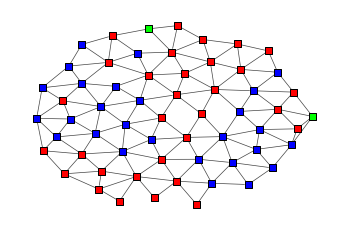

[]
0.8834345513953211
0.9692032603973488
1.9859171610294892
0.9666666666666667
0.26
9
0.0055


In [21]:
def test_distances():
    v1,v2 = g.vs[RNG.integers(0, high=g.vcount())], g.vs[RNG.integers(0, high=g.vcount())]
    oldclassv1 = v1['class']
    oldclassv2 = v2['class']
    oldcolorv1 = v1['color']
    oldcolorv2 = v2['color']
    
    print(v1,v2)
    v1['class']=2
    v2['class']=2
    v1['color']='green'
    v2['color']='green'
    showgraph(g)
    print(d_euclidean(g, v1,v2))
    print(d_manhatten(g, v1,v2))
    print(d_geodesic(g, v1,v2))
    print(d_jaccard(g, v1,v2, n_hop=10))
    print(d_randomWalk(g, v1,v2, walk_length=45, num_walks=100))
    print(d_randomWalk(g, v1,v2, walk_length=45, num_walks=100, retminlen=True))

    # custom distance measures
    dG_rw=distanceFnFactory(d_randomWalk, walk_length=getLongestPossiblePath(g), num_walks=1000, retminlen=False)
    print(dG_rw(g, v1,v2))

    v1['class']=oldclassv1
    v2['class']=oldclassv2
    v1['color']=oldcolorv1
    v2['color']=oldcolorv2

test_distances()

In [22]:
import queue



def dnhfactory(g, vertex, d):
    def rtfn(v):
        return distance_GraphObj(g, vertex, v) < d
    return rtfn
    
def triangleDeltaFactory(g, vx, vy, epsilon=0.0):
    def rtfn(v):
        if epsilon == 0.0:
            return distance_GraphObj(g, v, vx) + distance_GraphObj(g, v, vy) == distance_GraphObj(g, vx, vy)
        return distance_GraphObj(g, v, vx) + distance_GraphObj(g, v, vy) <= distance_GraphObj(g, vx, vy) + epsilon
    return rtfn

    
def Delta(g,x,y, epsilon=0.1):
    return set(g.vs.select(triangleDeltaFactory(g, x, y, epsilon=epsilon)))

def printset(s):
    idl = []
    for i in s:
        idl.append(id(i))
    print(idl)

def customSetIntersection(A, B):
    return A.intersection(B)

    
def ExtensionalWeaklyConvexHull(g, vertexset, theta, epsilon=0.0):
    g.vs['mark'] = 0
    C = set()
    E = set()
    Q = queue.Queue()
    for vertex in vertexset:
        vertex['mark']=1
        Q.put(vertex)
    
    while not Q.empty():
        el = Q.get()
        C.add(el)
        thetanh = set(g.vs.select(dnhfactory(g, el, theta)))
        for nhel in customSetIntersection(C,thetanh):
            E.add((el, nhel))
            distElNhel = distance_GraphObj(g, el, nhel)
            
            nhdistel = set(g.vs.select(dnhfactory(g, el, distElNhel)))
            nhdistnhel = set(g.vs.select(dnhfactory(g, nhel, distElNhel)))

            intersect = customSetIntersection(nhdistel,nhdistnhel)
            for z in intersect:
                if not z['mark']==1 and z in Delta(g, el, nhel, epsilon=epsilon):
                    z['mark']=1
                    Q.put(z)
    return C,E
        




33 27


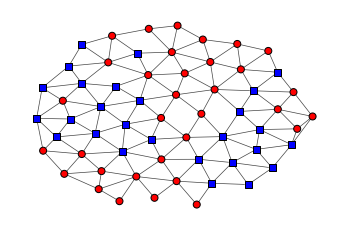

[]


In [42]:
C,E = ExtensionalWeaklyConvexHull(g, g.vs.select(class_eq=0), 0.2, epsilon=0.0)
showgraph(g)

50 0
0 0


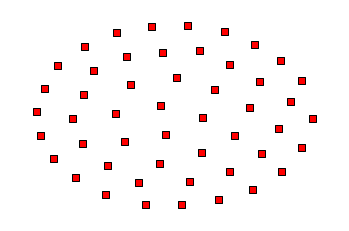

[]
33 17


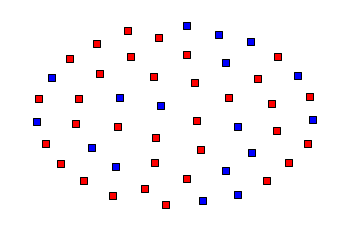

[]
33 17


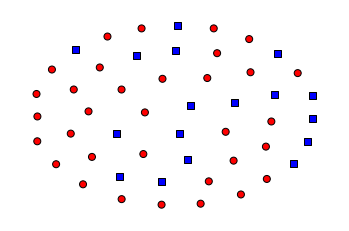

[]


In [24]:
def generateRandomPointCloud(n):
    global GLOBAL_DIMENSION
    global GLOBAL_SCALE_FACTOR
    
    
    g = ig.Graph(n=n, edges=[])
    coordinates = RNG.random(size=(n, GLOBAL_DIMENSION))*GLOBAL_SCALE_FACTOR
    g.vs['coordinates'] = coordinates.tolist()
    g.vs['class'] = -1
    g.vs['mark'] = 0
    layout = g.layout_auto()


    g.es['len'] = 0
    g.es['count'] = 1
    
    return g

h = generateRandomPointCloud(50)
print(h.vcount(), h.ecount())
showgraph(h)
genRandPartitioning(h)
showgraph(h)
ExtensionalWeaklyConvexHull(h, h.vs.select(class_eq=0), 1.5, epsilon=0.0)
showgraph(h)


In [25]:
def convSanity1(A, convexhullA):
    if len(convexhullA) == 0:
        return 0
    return len(A) / len(convexhullA)

def convSanity2(g, A, convexhullA, epsilon=0.0):
    if len(convexhullA) == 0:
        return 0
    g.vs['markwp'] = False
    pairslist = []
    for v1 in A:
        for v2 in A:
            if v1 != v2:
                pairslist.append((v1,v2))
    
    numberofwrongpoints = 0
    for pair in pairslist:
        x,y = pair
        for v in Delta(g,x,y, epsilon=epsilon).intersection(convexhullA):
            if v not in A and not v['markwp']:
                v['markwp'] = True
                numberofwrongpoints += 1

    g.vs['markwp'] = False
    return 1 - numberofwrongpoints / len(convexhullA)
    
def convSanity2sampled(g, A, convexhullA, epsilon=0.0, samplepercentage=0.3):
    if len(convexhullA) == 0:
        return 0
    g.vs['markwp'] = False
    pairslist = []

    numberofsamples = math.floor(len(A)*samplepercentage)
    drawA = [(index, element) for index, element in enumerate(list(A) if samplepercentage < 0.5 else list(A)+list(A))]
    while numberofsamples > 0:
        v1 = RNG.choice(drawA)
        v2 = RNG.choice(drawA)
        if v1[1] == v2[1] or (v1[0]-v2[0]) % len(A) == 0:
            continue
        pairslist.append((v1[1],v2[1]))
        drawA = list(filter(lambda item: item[0]!=v1[0] and item[0]!=v2[0],drawA))
        numberofsamples -= 1
    

    numberofwrongpoints = 0
    for pair in pairslist:
        x,y = pair
        for v in Delta(g,x,y, epsilon=epsilon).intersection(convexhullA):
            if v not in A and not v['markwp']:
                v['markwp'] = True
                numberofwrongpoints += 1

    g.vs['markwp'] = False
    return 1 - numberofwrongpoints / len(convexhullA)


def logarithmically_distributed_list(n, min_value=0.01, max_value=1.0):
    if n < 2:
        raise ValueError("The list length 'n' must be at least 2.")
    log_spaced_values = np.logspace(np.log10(min_value), np.log10(max_value), n)
    log_spaced_values[0] = min_value
    log_spaced_values[-1] = max_value

    return log_spaced_values

def trymeasure(g, A):
    lengthepsilon = 10
    lengththeta = 10
    epsilonvals = np.concatenate([[0],logarithmically_distributed_list(lengthepsilon-1, min_value=0.0001, max_value=1.0)])
    thetavals = np.concatenate([[0],logarithmically_distributed_list(lengththeta-1, min_value=0.0001, max_value=getMaxDistance(g))])
    print(epsilonvals, thetavals)
    res = []
    workingpairs = []
    maxepsilon = 0
    maxtheta = 0
    for epsilon in epsilonvals:
        for theta in thetavals:
            AConvNow = ExtensionalWeaklyConvexHull(g, A, theta, epsilon=epsilon)[0]
            res.append((epsilon, theta, len(A), len(AConvNow), convSanity1(A, AConvNow), convSanity2sampled(g, A, AConvNow, samplepercentage=0.1)))
            if len(A)!=len(AConvNow):
                pass
                #print(maxepsilon, maxtheta)
            else:
                oldmaxepsilon, oldmaxtheta = maxepsilon, maxtheta
                if not any([x[0]==epsilon and x[1]==theta for x in workingpairs]):
                    workingpairs.append((epsilon, theta))

                if epsilon > maxepsilon:
                    maxepsilon = epsilon
                    print(oldmaxepsilon, oldmaxtheta)
                if theta > maxtheta:    
                    maxtheta = theta
                    print(oldmaxepsilon, oldmaxtheta)
    return workingpairs


In [26]:
trymeasure(g, g.vs.select(class_eq=0))

# print(getMaxDistance(g))
# print(getMaxDistance(h))
# print(getMaxDistance(g, distfn=d_geodesic))
# print(getMaxDistance(h, distfn=d_geodesic))

# dG_rw=distanceFnFactory(d_randomWalk, walk_length=getLongestPossiblePath(g), num_walks=1000, retminlen=False)
# dG_Jaccard=distanceFnFactory(d_jaccard, n_hop=10)

# print("jg", getMaxDistance(g, distfn=dG_Jaccard))
# print("jh", getMaxDistance(h, distfn=dG_Jaccard))
# print(getMaxDistance(g, distfn=dG_rw))

# GLOBAL_DISTANCE_FN = d_geodesic
# print(getMaxDistance(g))
# GLOBAL_DISTANCE_FN = d_euclidean
# print(getMaxDistance(g))
# trymeasure(g, g.vs.select(class_eq=0))

[0.00000000e+00 1.00000000e-04 3.16227766e-04 1.00000000e-03
 3.16227766e-03 1.00000000e-02 3.16227766e-02 1.00000000e-01
 3.16227766e-01 1.00000000e+00] [0.00000000e+00 1.00000000e-04 3.26348913e-04 1.06503613e-03
 3.47573384e-03 1.13430196e-02 3.70178213e-02 1.20807258e-01
 3.94253172e-01 1.28664094e+00]
0 0
0 0.0001
0 0.000326348913332412
0 0.0010650361323324617
0 0.0034757338444645343
0 0.011343019631736876
0 0.03701782130725546
0 0.12080725757556213
0 0.394253172324535
0 1.2866409436596824


KeyboardInterrupt: 